In [227]:
# ---- LIBRARY IMPORTS ----
import torchtext
torchtext.disable_torchtext_deprecation_warning()
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import time
from datetime import timedelta
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
# Setting seed for reproducibility
torch.manual_seed(0)

# ---- DEVICE SET UP ----
def get_gpu():
    if torch.backends.mps.is_available():
        print("Using mps")
        return "mps"
    elif torch.cuda.is_available():
        print("Using cuda")
        return"cuda"
    else:
        print("Using CPU")
        return "cpu"
device = get_gpu()

Using mps


# Cleaning Data

In [228]:
# # ---- DATA IMPORT ----
# # Specify data types for each column
# dtypes = {0: "UInt64", 1: "string", 2: "string", "3": "UInt64"}
# # Import data
# data_raw = pd.read_csv('data/fake_news/news_data.csv', dtype=dtypes)
# # Remove NA values
# data_no_na = data_raw.dropna()
# # Drop columns 
# data_drop_columns = data_no_na.drop(columns=['Unnamed: 0', 'title'])
# # Drop duplicate rows
# clean_data = data_drop_columns.drop_duplicates()

In [230]:
# ---- READ IN NEW DATA ----
dypes = {'text': str, 'label': 'Int64'}
clean_data = pd.read_csv("data/fake_news/news_data.csv", dtype=dypes)
# Drop empty strings
clean_data = clean_data.dropna()
clean_data = clean_data.sample(n=1000, random_state=0)
# clean_data.shape

In [231]:
"""
---- CLEANING TEXT DATA ----
The following steps will be taken to clean data
- all non-alphabetical data will be removed
- all emails and web urls will be removed
- all stop words will be removed based on the stop words in the ntlk dictionary
- all text will be made lowercase
"""


# # function to lemmatize words
# def pos_lemmatize(text):
#     tokens = word_tokenize(text)
#     pos_tags = pos_tag(tokens)
#     lemmatized_tokens = [lemmatizer.lemmatize(token, wordnet_pos(tag)) for token, tag in pos_tags]
#     return ' '.join(lemmatized_tokens)

# Regex function to clean strings
def regex_cleaner(text):
    try:
    # remove any web urls
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    # remove email addresses
        text = re.sub(r'\b\w+@\w+\.\w+\b', '', text) 
    # Make all text lowercase
        text_lowercase = text.lower()
    # Remove all non-alphanumeric text
        text_alphanumeric = re.sub(r'[^a-z\s\-]', '', text_lowercase)
    # Combine words that overlap to a new line
        no_overlap = re.sub(r'(\-\n)', '', text_alphanumeric)
    # remove \n and "-"
        no_new_line = re.sub(r'[\n\-]', ' ', no_overlap)
    # Remove extra spacing
        clean_text = re.sub(r'\s+', r' ', no_new_line)
        return clean_text
    except:
        raise Exception("Something went wrong :(")

# Clean text data!
clean_data['text'] = clean_data['text'].apply(regex_cleaner)
clean_data['text'] = clean_data['text'].apply(lambda x: pos_lemmatize(str(x)))

# Drop NA values if any
clean_data = clean_data.dropna()

# Write to csv to avoid wait time with tokenization
# clean_data.to_csv('data/fake_news/clean_news_data.csv', index=False)

In [232]:
# split data into train, test sets
train, test = train_test_split(clean_data, test_size=0.2, random_state=0)

# Create an iterator object for train and test data
data_iter = clean_data.iterrows()
train_iter = train.iterrows()
test_iter = test.iterrows()

# Convert generators to list of tuples because DataLoader does not work well with pandas dataframes
# Use this as inputs for DataLoader
data_list_of_tuples = [(row.text, row.label) for index, row in data_iter]
train_list_of_tuples = [(row.text, row.label) for index, row in train_iter]
test_list_of_tuples = [(row.text, row.label) for index, row in test_iter]

"""
Tokenization for word sequences
"""
def yield_tokens(data):
    """
    Pull the text data from series to tokenize it
    Each row is a series when calling the iterrows() method, you must call the text column to pull its value
    """
    tokenizer = get_tokenizer("basic_english")
    for index, row in data.iterrows():
        text = row.text
        yield tokenizer(text)

"""
vocab_dict is now a function that takes a list of words as an input and returns integers based on the indexes found in the vocab_dict's dictionary
<unk> -> In case a word is not in vocab_dict, we default it to a special index for words not in vocab_dict
"""
vocab_dict = build_vocab_from_iterator(iterator=yield_tokens(clean_data), specials=["<unk>"], max_tokens=150000)
vocab_dict.set_default_index(vocab_dict["<unk>"])
# text_sequencer is a function that takes a string and returns a list of integers based off vocab_dict
tokenizer = get_tokenizer(tokenizer=None)
text_sequencer = lambda string: vocab_dict(tokenizer(string))


def collate_batch(batch):
    """
    This function takes a batch created from the DataLoader function and does data preprocessing to it
    """
    labels, text_tensors_list = [], []
    for example in batch:
    # Get data from pandas series
        text = example[0]
        label = example[1]
    # convert text to sequences of integers
        text_sequence = text_sequencer(text)
    # convert text_sequence to tensor
        text_sequence_tensor = torch.tensor(text_sequence, dtype=torch.int64)

    # append tensors to lists
        labels.append(label)
        text_tensors_list.append(text_sequence_tensor)
# add padding of 0 to text_tensors (All articles have a different number of words and we want all tensors to be the same size)
    text_tensors = pad_sequence(text_tensors_list, batch_first=True, padding_value = 0)
# convert labels lists to tensor
    labels_tensor = torch.tensor(labels, dtype=torch.int64)
    return labels_tensor.to(device), text_tensors.to(device)

# Model Building

## RNN

In [221]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_dimensions, nbr_layers_rnn, batch_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
    # this converts your sequence of words to a vector to pass through the NN
        self.word_sequence_to_embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dimensions)
        """
        Your RNN (bi-directional=True creates a bi-directional RNN)
        - A bi-directional RNNs are well suited for jobs that call for knowledge of the context and connections among sequence elements
        """
        self.rnn = nn.RNN(input_size=embedding_dimensions, hidden_size=hidden_size, num_layers=nbr_layers_rnn, batch_first=True,  dropout=0.5, bidirectional=False)
    # # Fully connected layer
    #     self.fully_connected = nn.Linear(in_features=hidden_size, out_features=64)
 
    # Drop out
        self.drop = nn.Dropout(0.5)
    # fully_connected_two = nn.Linear
        self.fully_connected_two = nn.Linear(in_features=hidden_size, out_features=1)

    # Apply xavier normal weights
        torch.nn.init.xavier_normal_(self.fully_connected_two.weight)
    # Sigmoid activation
        self.activation = nn.Sigmoid()

    def forward(self, input_, hidden):
    # Create sequence embeddings
        sequence_embeddings = self.word_sequence_to_embedding(input_)
    # Compute output and hidden layers of RNN
        output, hidden = self.rnn(sequence_embeddings, hidden)

        
    # # Compute fully connected layer
    #     fully_connected = self.fully_connected(output)

    # Add drop out
        drop = self.drop(output)

        fully_connected_two = self.fully_connected_two(drop)
        # torch.sum(fully_connected_two, axis=1)
    # Since embeddings are of the shape (Example, term, term_features), we must reduce to a matrix by taking the average 
        fully_connected_reduced = torch.mean(fully_connected_two, axis=1) # mean of word vector
        # print(fully_connected_reduced.shape)
    # Sigmoid Activation
        output = self.activation(fully_connected_reduced)
        return output, hidden.detach()

    def initHidden(self):
    # Return a matrix of 1 row and k columns where k=hidden_size
        return torch.zeros(nbr_layers_rnn, batch_size, self.hidden_size).to(device)
        

In [222]:
embedding_dimensions = 75
# this is the number of recurrent layers 
nbr_layers_rnn = 4
n_hidden = 128
batch_size = 4
input_size = len(vocab_dict)
rnn_model = RNN(input_size=input_size, hidden_size=n_hidden, embedding_dimensions=embedding_dimensions, nbr_layers_rnn=nbr_layers_rnn, batch_size=batch_size)
rnn_model.to(device)

RNN(
  (word_sequence_to_embedding): Embedding(7488, 75)
  (rnn): RNN(75, 128, num_layers=4, batch_first=True, dropout=0.5)
  (drop): Dropout(p=0.5, inplace=False)
  (fully_connected_two): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)

### Fitting the Model

In [223]:
# Convert sigmoid activations to labels
def get_labels(results):
    decision = lambda val: 1 if val >= 0.5 else 0
    labels = torch.where(results > 0.5, 1.0, 0.0)
    return labels

In [224]:
# Create Train and Test DataLoaders
train_loader = torch.utils.data.DataLoader(train_list_of_tuples, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_list_of_tuples, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)

# Create Loss function
criterion = nn.BCELoss()

# Create Optimizer
# optimizer = optim.SGD(rnn_model.parameters(), lr=0.005, momentum=0.9)
optimizer = optim.SGD(rnn_model.parameters(), lr=0.005)
# Create Method to change learning rate by a factor of lr*0.1 after every epoch that doesn't have an effect on the loss function
scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.01)

In [225]:
# epoch_iter = 20
def fit_rnn(model, trainloader, testloader, nbr_of_epochs, optimizer, criterion):
# Dictionary of epoch results
    epoch_results = {}
# Iterate through epochs
    for epoch in range(nbr_of_epochs):
    # ---- MODEL TRAINING ----

    # Initialize hidden layer
        hidden = model.initHidden()
    # Put model in training mode
        model.train()
    # Start timer for trainig of epoch
        start_time = time.perf_counter()
    # Initalize the batch number currently being worked on
        batch_nbr = 0
    # Create loss variable for epoch
        training_losses = 0.0
    # Total examples labeld correctly in epoch
        training_total_correct = 0.0
    # Total number of examples in epoch
        training_total_examples = 0.0
    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0
    # Execute Forward, Backward, Optimization

    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0


    # Iterate through data
        for labels, inputs in trainloader:
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.float().to(device)
        # Detach the hidden layer so we don't compute gradient across hidden layers
            hidden = hidden.detach()
        # Zero the parameter gradients
            optimizer.zero_grad()

        # ---- FORWARD, BACKWARD, OPTIMIZE ----
        # Get model training predictions
            outputs, hidden = model(inputs, hidden)
            outputs = torch.squeeze(outputs, 1)
        # Convert model training predictions to their respective classifications
            predicted_labels = get_labels(outputs)
        # Compute Loss of current batch
            loss = criterion(outputs, labels)

        # # ---- LASSO Regularization ----
        # # Initialize regularization loss penalty
        #     total_abs_weight = sum([torch.sum(torch.abs(beta)).item() for beta in model.parameters()])
        #     total_number_of_model_weights = sum([torch.numel(beta) for beta in model.parameters()])
        #     avg_abs_weight = total_abs_weight/total_number_of_model_weights
        # # Add penaltiy to loss
        #     lambda_ = 0.01
        #     loss += lambda_ * avg_abs_weight

        # Compute total number of correctly classified examples
            nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
        # Grab batch size
            total_nbr_of_elements = labels.shape[0]
        # Compute number of correctly labeled examples and the total exampes
            training_total_correct += nbr_of_correct_predictions
            training_total_examples += total_nbr_of_elements

        # del labels, inputs from memory
            del labels
            del outputs

        # Backward pass
            loss.backward()
        # Update model params with gradient clippings
            nn.utils.clip_grad_norm_(model.parameters(), 0.01)
        # Initalize the next step of optimizer
            optimizer.step()
        # update training loss of epoch
            training_losses += float(loss.item())*total_nbr_of_elements
        #  update the current batch number of epoch
            batch_nbr += 1
    # End training time
        end_time = time.perf_counter()
    # Get total runntime of epoch
        epoch_runtime = timedelta(seconds=end_time-start_time).total_seconds()

        with torch.no_grad():
        # init hidden state
            hidden_test = model.initHidden()

        # Iterate through data
            for labels, inputs in testloader:
            # get the inputs; data is a list of [inputs, labels]
                inputs, labels = inputs.to(device), labels.float().to(device)
            # Detach the hidden layer so we don't compute gradient across hidden layers
                hidden_test = hidden_test.detach()


            # ---- FORWARD, BACKWARD, OPTIMIZE ----
            # Get model training predictions
                outputs, hidden_test = model(inputs, hidden_test)
                outputs = torch.squeeze(outputs, 1)
            # Convert model training predictions to their respective classifications
                predicted_labels = get_labels(outputs)
            # Compute Loss of current batch
                loss = criterion(outputs, labels)

    # Compute total number of correctly classified examples
        nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
    # Grab batch size
        total_nbr_of_elements = labels.shape[0]
    # Compute number of correctly labeled examples and the total exampes
        testing_total_correct += nbr_of_correct_predictions
        testing_total_examples += total_nbr_of_elements


    # ---- COMPUTING ACCURACY/LOSS ----
    # Compute training accuracy/loss of epoch
        total_training_epoch_loss = round(training_losses/len(trainloader), 4)
        training_accuracy = round(training_total_correct/training_total_examples, 4)
    # Compute training accuracy/loss of epoch
        total_testing_epoch_loss = round(testing_losses/len(testloader), 4)
        testing_accuracy = round(testing_total_correct/testing_total_examples, 4)

        # ---- LEARNING RATE ----
        # # Current learning rate
        #     current_lr = scheduler.get_last_lr()
        # # Adjust learning rate
        #     scheduler.step()

        # ---- RESULTS ----
    # print results of epoch
        print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s  <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
        # print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s <-> Learning Rate: {current_lr} <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
    # Update results of epochs
        result_dict = { "runtime": epoch_runtime,#"learning_rate": current_lr,
                        "training_loss": total_training_epoch_loss, 'training_accuracy': training_accuracy,
                        "testing_loss": total_testing_epoch_loss, 'testing_accuracy': testing_accuracy,}
        epoch_results.update({epoch+1: result_dict})
    return epoch_results

In [226]:
epochs_results = fit_rnn(model=rnn_model, trainloader=train_loader, testloader=test_loader, nbr_of_epochs=epoch_iter, optimizer=optimizer, criterion=criterion)

Epoch 1/20 <-> Runtime: 35.0s  <-> Training loss: 2.781 <-> Training Accuracy: 0.525 <-> Testing Loss: 2.781 <-> Testing Accuracy: 0.75


KeyboardInterrupt: 

# Visualizations

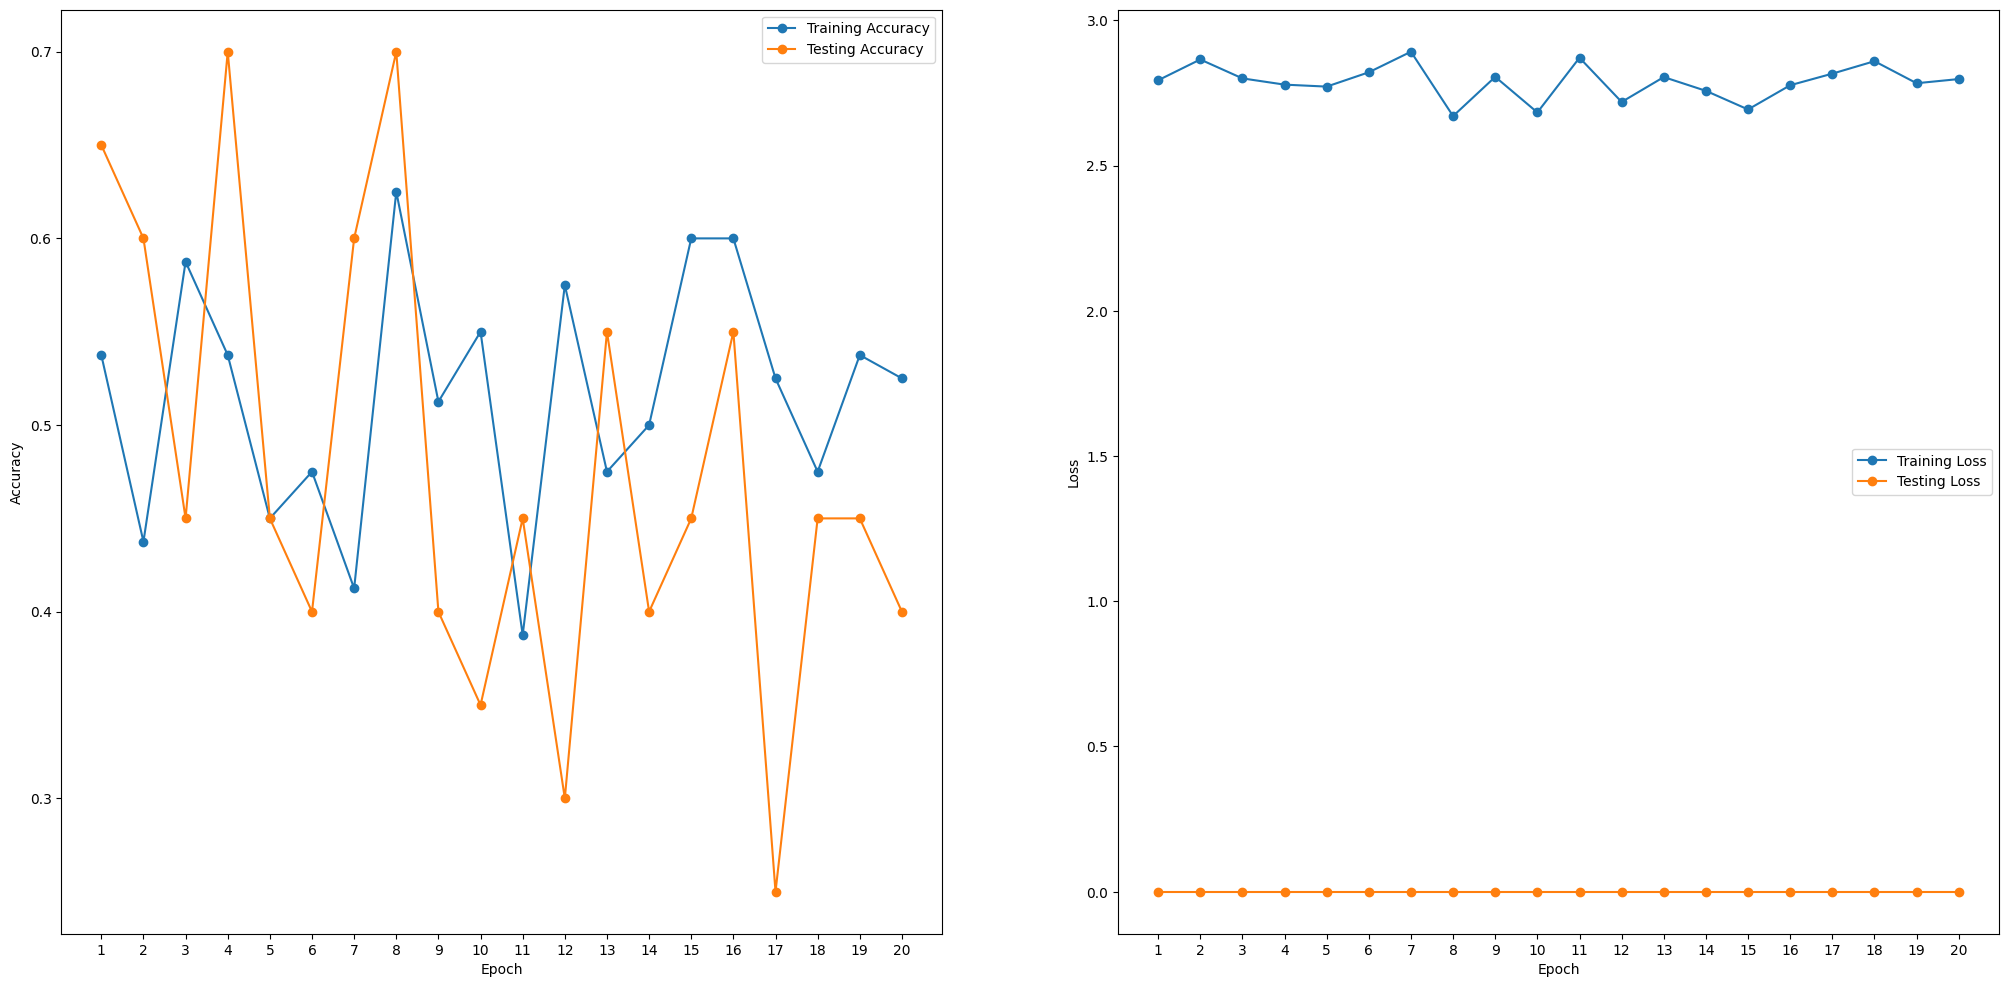

In [112]:
# ---- PLOTTING GRAPH OF LSS AND ACCURACY TO NUMBER OF EPOCH ----
fig, ((ax_one), (ax_two)) = plt.subplots(1, 2)


# ---- TRAINING AND TESTING ACCURACY TO EPOCH ----
epoch_accuracy = {"training_accuracy": [epochs_results.get(epoch).get('training_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "testing_accuracy": [epochs_results.get(epoch).get('testing_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('training_accuracy'), linestyle='-', marker='o')
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('testing_accuracy'), linestyle='-', marker='o')
ax_one.legend(['Training Accuracy', 'Testing Accuracy'])
ax_one.set_xticks(epoch_accuracy.get('epoch'), labels=epoch_accuracy.get('epoch'))
ax_one.set_xlabel("Epoch")
ax_one.set_ylabel("Accuracy")

# ---- TRAINING AND TESTING LOSS TO EPOCH ----
epoch_loss = {"training_loss": [epochs_results.get(epoch).get('training_loss') for epoch in range(1, max(epochs_results.keys())+1)], "testing_loss": [epochs_results.get(epoch).get('testing_loss') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('training_loss'), linestyle='-', marker='o')
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('testing_loss'), linestyle='-', marker='o')
ax_two.legend(['Training Loss', 'Testing Loss'])
ax_two.set_xticks(epoch_loss.get('epoch'), labels=epoch_loss.get('epoch'))
ax_two.set_xlabel("Epoch")
ax_two.set_ylabel("Loss")



fig.set_figheight(12)
fig.set_figwidth(25)
plt.show()

# References
[https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

[https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/](https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/)

[https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/#](https://www.geeksforgeeks.org/adjusting-learning-rate-of-a-neural-network-in-pytorch/#)

[https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

[Bi-directional RNN](https://www.geeksforgeeks.org/bidirectional-recurrent-neural-network/)

## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_dimensions, nbr_layers_rnn, batch_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.nbr_layers_rnn = nbr_layers_rnn
        self.input_size = input_size
        self.batch_size = batch_size
    # this converts your sequence of words to a vector to pass through the NN
        self.word_sequence_to_embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dimensions)
        """
        Your RNN (bi-directional=True creates a bi-directional RNN)
        - A bi-directional RNNs are well suited for jobs that call for knowledge of the context and connections among sequence elements
        """
        self.lstm = nn.LSTM(input_size=embedding_dimensions, hidden_size=hidden_size, num_layers=nbr_layers_rnn, batch_first=True,  dropout=0.2, bidirectional=False)
    # Fully connected layer
        self.fully_connected = nn.Linear(in_features=hidden_size, out_features=24)

    # Apply xavier normal weights
        torch.nn.init.xavier_normal_(self.fully_connected.weight)
    # Drop out
        self.drop = nn.Dropout(0.2)
    # fully_connected_two = nn.Linear
        self.fully_connected_two = nn.Linear(in_features=24, out_features=1)
    # Sigmoid activation
        self.activation = nn.Sigmoid()

    def forward(self, input_, hidden_tuple):
    # Create sequence embeddings
        sequence_embeddings = self.word_sequence_to_embedding(input_)
    # Compute output and hidden layers of RNN
        output, hidden_tuple = self.lstm(sequence_embeddings, hidden_tuple)

        
    # Compute fully connected layer
        fully_connected = self.fully_connected(output)

    # Add drop out
        drop = self.drop(fully_connected)

        fully_connected_two = self.fully_connected_two(drop)
        
    # Since embeddings are of the shape (Example, term, term_features), we must reduce to a matrix by taking the average 
        fully_connected_reduced = fully_connected_two[:, -1, :]
    # Sigmoid Activation
        output = self.activation(fully_connected_reduced)
        return output, hidden_tuple

    def initHidden(self):
    # Return a matrix of 1 row and k columns where k=hidden_size
        return (torch.zeros(self.nbr_layers_rnn, self.batch_size, self.hidden_size).to(device), 
                torch.zeros(self.nbr_layers_rnn, self.batch_size, self.hidden_size).to(device))
        

In [ ]:
embedding_dimensions = 75
# this is the number of recurrent layers 
nbr_layers_rnn = 4
n_hidden = 128
batch_size = 4
input_size = len(vocab_dict)
lstm_model = LSTM(input_size=input_size, hidden_size=n_hidden, embedding_dimensions=embedding_dimensions, nbr_layers_rnn=nbr_layers_rnn, batch_size=batch_size)
lstm_model.to(device)

In [ ]:
# Create Loss function
lstm_criterion = nn.BCELoss()

# Create Optimizer
lstm_optimizer = optim.SGD(lstm_model.parameters(), lr=0.005, momentum=0.9)
# lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.005)
# Create Method to change learning rate by a factor of lr*0.1 after every epoch that doesn't have an effect on the loss function
# scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.01)

In [ ]:
epoch_iter = 2
def fit_lstm(model, trainloader, testloader, nbr_of_epochs, optimizer, criterion):
# Dictionary of epoch results
    epoch_results = {}
# Put model in training mode    
    model.train()
# Iterate through epochs
    for epoch in range(nbr_of_epochs):
    # ---- MODEL TRAINING ----

    # Initialize hidden layer
        hidden_tuple = model.initHidden()
    
    # Start timer for trainig of epoch
        start_time = time.perf_counter()
    # Initalize the batch number currently being worked on
        batch_nbr = 0
    # Create loss variable for epoch
        training_losses = 0.0
    # Total examples labeld correctly in epoch
        training_total_correct = 0.0
    # Total number of examples in epoch
        training_total_examples = 0.0
    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0
    # Execute Forward, Backward, Optimization
    
    # Create loss variable for epoch
        testing_losses = 0.0
    # Total examples labeld correctly in epoch
        testing_total_correct = 0.0
    # Total number of examples in epoch
        testing_total_examples = 0.0

        
    # Iterate through data
        for labels, inputs in trainloader:
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.float().to(device)
        # Detach the hidden layer so we don't compute gradient across hidden layers
            # hidden_tuple[0].detach()
            # hidden_tuple[1].detach()

        # Zero the parameter gradients
            optimizer.zero_grad()

        # ---- FORWARD, BACKWARD, OPTIMIZE ----
        # Get model training predictions
            outputs, hidden_tuple = model(inputs, hidden_tuple)
            outputs = torch.squeeze(outputs, 1)
        # Convert model training predictions to their respective classifications
            predicted_labels = get_labels(outputs)
        # Compute Loss of current batch            
            loss = criterion(outputs, labels)

        # ---- LASSO Regularization ----
        # Initialize regularization loss penalty
            total_abs_weight = sum([torch.sum(torch.abs(beta)).item() for beta in model.parameters()])
            total_number_of_model_weights = sum([torch.numel(beta) for beta in model.parameters()])
            avg_abs_weight = total_abs_weight/total_number_of_model_weights
        # Add penaltiy to loss
            lambda_ = 0.01
            loss += lambda_ * avg_abs_weight

        # Compute total number of correctly classified examples
            nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
        # Grab batch size
            total_nbr_of_elements = labels.shape[0]
        # Compute number of correctly labeled examples and the total exampes
            training_total_correct += nbr_of_correct_predictions
            training_total_examples += total_nbr_of_elements

        # Backward pass
            loss.backward(retain_graph=True) 
        # Update model params with gradient clippings
            nn.utils.clip_grad_norm_(model.parameters(), 2.5)
        # Initalize the next step of optimizer
            optimizer.step()
        # update training loss of epoch
            training_losses += float(loss.item())*total_nbr_of_elements
        #  update the current batch number of epoch
            batch_nbr += 1
    # End training time
        end_time = time.perf_counter()
    # Get total runntime of epoch
        epoch_runtime = timedelta(seconds=end_time-start_time).total_seconds()


    # init hidden state
        hidden_test_tuple = model.initHidden()

    # Iterate through data
        for labels, inputs in testloader:
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.float().to(device)
        # Detach the hidden layer so we don't compute gradient across hidden layers
            hidden_test_tuple[0].detach()
            hidden_test_tuple[1].detach()
            # hidden_test_tuple = (hidden_test_tuple[0].detach, hidden_test_tuple[1].detach)
        
            
        # ---- FORWARD, BACKWARD, OPTIMIZE ----
        # Get model training predictions
            outputs, hidden_test_tuple = model(inputs, hidden_test_tuple)
            outputs = torch.squeeze(outputs, 1)
        # Convert model training predictions to their respective classifications
            predicted_labels = get_labels(outputs)
        # Compute Loss of current batch            
            loss = criterion(outputs, labels)

        # ---- LASSO Regularization ----
        # Initialize regularization loss penalty
            total_abs_weight = sum([torch.sum(torch.abs(beta)).item() for beta in model.parameters()])
            total_number_of_model_weights = sum([torch.numel(beta) for beta in model.parameters()])
            avg_abs_weight = total_abs_weight/total_number_of_model_weights
        # Add penaltiy to loss
            lambda_ = 0.01
            loss += lambda_ * avg_abs_weight

        # Compute total number of correctly classified examples
            nbr_of_correct_predictions = torch.sum(predicted_labels == labels).item()
        # Grab batch size
            total_nbr_of_elements = labels.shape[0]
        # Compute number of correctly labeled examples and the total exampes
            testing_total_correct += nbr_of_correct_predictions
            testing_total_examples += total_nbr_of_elements

        # del labels, inputs from memory
            del labels
            del outputs

    # ---- COMPUTING ACCURACY/LOSS ----
    # Compute training accuracy/loss of epoch
        total_training_epoch_loss = round(training_losses/len(trainloader), 4)
        training_accuracy = round(training_total_correct/training_total_examples, 4)
    # Compute training accuracy/loss of epoch
        total_testing_epoch_loss = round(testing_losses/len(testloader), 4)
        testing_accuracy = round(testing_total_correct/testing_total_examples, 4)

    # ---- LEARNING RATE ----
    # Current learning rate
        current_lr = scheduler.get_last_lr()
    # Adjust learning rate
        scheduler.step()

    # ---- RESULTS ----
    # print results of epoch
        # print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
        print(f'Epoch {epoch + 1}/{epoch_iter} <-> Runtime: {round(epoch_runtime, 0)}s <-> Learning Rate: {current_lr} <-> Training loss: {total_training_epoch_loss} <-> Training Accuracy: {training_accuracy} <-> Testing Loss: {total_training_epoch_loss} <-> Testing Accuracy: {testing_accuracy}')
    # Update results of epochs
        # result_dict = { "runtime": epoch_runtime,
        #                "training_loss": total_training_epoch_loss, 'training_accuracy': training_accuracy,
        #                "testing_loss": total_testing_epoch_loss, 'testing_accuracy': testing_accuracy,}
        result_dict = { "runtime": epoch_runtime, #"learning_rate": current_lr, 
                       "training_loss": total_training_epoch_loss, 'training_accuracy': training_accuracy,
                       "testing_loss": total_testing_epoch_loss, 'testing_accuracy': testing_accuracy,}
        epoch_results.update({epoch+1: result_dict})
    return epoch_results

In [ ]:
epochs_results = fit_lstm(model=lstm_model, trainloader=train_loader, testloader=test_loader, nbr_of_epochs=epoch_iter, optimizer=lstm_optimizer, criterion=lstm_criterion)

In [ ]:
# ---- PLOTTING GRAPH OF LSS AND ACCURACY TO NUMBER OF EPOCH ----
fig, ((ax_one), (ax_two)) = plt.subplots(1, 2)


# ---- TRAINING AND TESTING ACCURACY TO EPOCH ----
epoch_accuracy = {"training_accuracy": [epochs_results.get(epoch).get('training_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "testing_accuracy": [epochs_results.get(epoch).get('testing_accuracy') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('training_accuracy'), linestyle='-', marker='o')
ax_one.plot(epoch_accuracy.get('epoch'), epoch_accuracy.get('testing_accuracy'), linestyle='-', marker='o')
ax_one.legend(['Training Accuracy', 'Testing Accuracy'])
ax_one.set_xticks(epoch_accuracy.get('epoch'), labels=epoch_accuracy.get('epoch'))
ax_one.set_xlabel("Epoch")
ax_one.set_ylabel("Accuracy")

# ---- TRAINING AND TESTING LOSS TO EPOCH ----
epoch_loss = {"training_loss": [epochs_results.get(epoch).get('training_loss') for epoch in range(1, max(epochs_results.keys())+1)], "testing_loss": [epochs_results.get(epoch).get('testing_loss') for epoch in range(1, max(epochs_results.keys())+1)], "epoch":[epoch for epoch in range(1, max(epochs_results.keys())+1)]}
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('training_loss'), linestyle='-', marker='o')
ax_two.plot(epoch_loss.get('epoch'), epoch_loss.get('testing_loss'), linestyle='-', marker='o')
ax_two.legend(['Training Loss', 'Testing Loss'])
ax_two.set_xticks(epoch_loss.get('epoch'), labels=epoch_loss.get('epoch'))
ax_two.set_xlabel("Epoch")
ax_two.set_ylabel("Loss")
plt.set_title("hbhk")


fig.set_figheight(12)
fig.set_figwidth(25)
plt.show()
plt.sav

In [95]:
test = torch.tensor([
    [[2, 4],
    [2, 4]
]])

torch.mean(test, axis=0, dtype=float)

tensor([[2., 4.],
        [2., 4.]], dtype=torch.float64)